In [9]:
%matplotlib inline
import autograd.numpy as np
import autograd.numpy.random as npr

from autograd import grad
from autograd.misc.optimizers import adam

import pandas as pd
from pandas import DataFrame

import os

In [2]:
inv_action_map = {}
for iv in range(5):
    for vaso in range(5):
        inv_action_map[5*iv+vaso] = np.array([iv,vaso])

# the non-static variables
variable_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
                    20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 42, 43, 44, 45, 47]

In [3]:
def load_data_test():
    dire = 'converted_data/'

    train_feat_zeros = np.loadtxt(dire + 'X_train_hist_zeros.txt')
    train_targets = np.loadtxt(dire + 'Y_train_hist_zeros.txt')
    print ("Loaded train_zeros")

    val_feat_zeros = np.loadtxt(dire + 'X_val_hist_zeros.txt')
    val_targets = np.loadtxt(dire + 'Y_val_hist_zeros.txt')
    print ("Loaded val_zeros")

    return train_feat_zeros,train_targets, val_feat_zeros, val_targets

In [10]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
X_train, Y_train,  X_val, Y_val = load_data_test()

Loaded train_zeros
Loaded val_zeros


In [11]:
df_train = pd.read_csv('../data/rl_train_set_unscaled.csv')
df_val = pd.read_csv('../data/rl_val_set_unscaled.csv')

In [151]:
rbf = lambda x: 0.6*np.exp(-x**2)
relu = lambda x: np.maximum(x, 0.01*x)
tanh = lambda x: 0.6*np.tanh(x)

class BNNEnvModel():
    def __init__(self, feat_shape, label_shape):
        self.iv_mean = float(np.load('iv_mean.npy'))
        self.iv_std = float(np.load('iv_std.npy'))

        self.vaso_mean = float(np.load('vaso_mean.npy'))
        self.vaso_std = float(np.load('vaso_std.npy'))

        self.sofa_index = 179 # state vector has 150 elements from previous timestep; 30 elements in is SOFA. index = (150+30) -1
        self.lact_index = 152 # state vector has 150 elements from previous timestep; 3 elements in is SOFA. index = (150+3) -1

        # load in the saved factors for the rewards
        self.sofa_mean = float(np.load('../data/sofa_mean.npy'))
        self.sofa_std = float(np.load('../data/sofa_std.npy'))
        self.lact_mean = float(np.load('../data/lact_mean.npy'))
        self.lact_std = float(np.load('../data/lact_std.npy'))

        self.num_weights, self.predictions, self.logprob =  self.make_nn_funs(
            layer_sizes=[feat_shape, 10, 10, label_shape], L2_reg=2,
                 noise_variance=1, nonlinearity=tanh)

        self.mean = None
        self.log_std = None

        self._do_restore()

    def make_nn_funs(self,layer_sizes, L2_reg, noise_variance, nonlinearity=np.tanh):
        """These functions implement a standard multi-layer perceptron,
        vectorized over both training examples and weight samples."""
        shapes = list(zip(layer_sizes[:-1], layer_sizes[1:]))
        num_weights = sum((m+1)*n for m, n in shapes)

        def unpack_layers(weights):
            num_weight_sets = len(weights)
            for m, n in shapes:
                yield weights[:, :m*n]     .reshape((num_weight_sets, m, n)),\
                      weights[:, m*n:m*n+n].reshape((num_weight_sets, 1, n))
                weights = weights[:, (m+1)*n:]

        def predictions(weights, inputs):
            """weights is shape (num_weight_samples x num_weights)
               inputs  is shape (num_datapoints x D)"""
#             print(weights.shape, inputs.shape)
            inputs = np.expand_dims(inputs, 0)
            for W, b in unpack_layers(weights):
#                 print(W.shape, b.shape)
                outputs = np.einsum('mnd,mdo->mno', inputs, W) + b
                inputs = nonlinearity(outputs)
            outputs = 1.5*np.tanh(outputs)
            return outputs

        def logprob(weights, inputs, targets):
            log_prior = -L2_reg * np.sum(weights**2, axis=1)
            preds = predictions(weights, inputs)
            log_lik = -np.sum((preds - targets)**2, axis=1)[:, 0] / noise_variance
            return log_prior + log_lik

        return num_weights, predictions, logprob
    
    def _do_restore(self):
        params = np.load('glob_params.npy')
        self.mean, self.log_std = self.unpack_params(params)

    # need to be able to return next state, of dimension (bs, 198) with the correct stacking
    def step(self,cur_state, action, terminal=False):
        
        # print("SHAPE ", action.shape)
        # run a forward pass to get the output (delta_t)
        if cur_state.ndim <2: 
            cur_state = cur_state[np.newaxis,:]
        
        action_as_arr = action
#         action_as_arr = np.array([inv_action_map[a] for a in action])

        # normalise IV
        action_as_arr[:,0] = (action_as_arr[:,0] - self.iv_mean)/self.iv_std
        action_as_arr[:,1] = (action_as_arr[:,1] - self.vaso_mean)/self.vaso_std
        
        inp = np.hstack([cur_state, action_as_arr])

        rs = npr.RandomState(0)
        sample_weights = rs.randn(1, self.num_weights) * np.exp(self.log_std) + self.mean

        delta_t = np.mean(self.predictions(sample_weights, inp), axis=0)
        
        delta_t_state = delta_t[:,:-1] # last entry is mortality flag
        next_state = self._get_next_state(delta_t_state, cur_state, action)

        reward = np.expand_dims(np.array(self._get_reward(cur_state, next_state)), axis=1)
        term_reward = np.expand_dims(np.array(self._get_term_reward(delta_t)), axis=1)
        
        # if terminal:
        #     reward += term_reward
        
#         print("REWARD ", np.mean(reward))
        
        return next_state, reward


    def _get_next_state(self,delta_t, cur_state, action):
        
        # print("Action shape ", action.shape)
        # cur_state is batch_size x 198

        # new_state_with_hist is bs x 148
        # print(cur_state.shape)
        new_state_with_hist = cur_state[:, 50:]
        s_t_next = np.copy(new_state_with_hist[:, 100:])
        # print(s_t_next.shape)
        # print(s_t_next[range(len(s_t_next)), variable_indices].shape)
        # print(delta_t.shape)
        s_t_next[:, variable_indices] += delta_t
        
        action_as_arr = action

#         action_as_arr = np.array([inv_action_map[a] for a in action])

        # normalise IV
        action_as_arr[:,0] = (action_as_arr[:,0] - self.iv_mean)/self.iv_std
        action_as_arr[:,1] = (action_as_arr[:,1] - self.vaso_mean)/self.vaso_std
        
        new_state_with_hist = np.hstack([new_state_with_hist, action_as_arr])
        
        # stack this next state onto the new_state_with_hist
        new_state_with_hist = np.append(new_state_with_hist, s_t_next, axis=1)
        return new_state_with_hist

    def _get_reward(self, cur_state, next_state):
        c0 = -1.0/4
        c1 = -1
        c2 = -2
        
        #grab the right cols
        sofa_now = cur_state[:, self.sofa_index]
        lact_now = cur_state[:, self.lact_index]
        
        sofa_next = next_state[:, self.sofa_index]
        lact_next = next_state[:, self.lact_index]
        
        # unscale the sofa/lactate
        sofa_now = sofa_now * self.sofa_std + self.sofa_mean
        sofa_next = sofa_next * self.sofa_std + self.sofa_mean
        
        lact_now = lact_now * self.lact_std + self.lact_mean
        lact_next = lact_next * self.lact_std + self.lact_mean
        
#         print("SOFA NOW %f, LACTATE NOW %f" % (np.mean(sofa_now), np.mean(lact_now)))
        
#         print("SOFA NEXT %f, LACTATE NEXT %f" % (np.mean(sofa_next), np.mean(lact_next)))
        
        #reward function: R(t) = c0*(T.tanh(sofa_now)) + c1(sofa_next-sofa_now) + c2*T.tanh(lact_next-lact_now)
        # TODO do we want to tanh the change in SOFA score too?
        # reward = c0*np.tanh(sofa_now) + c1*(sofa_next-sofa_now) + c2*np.tanh(lact_next-lact_now)
        reward = c1*(sofa_next-sofa_now)
        return reward

    def _get_term_reward(self,delta_t):
        # terminal reward is the final element of delta_t multiplied by 15
        return 15 * delta_t[:,-1]

    def unpack_params(self,params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:self.num_weights], params[self.num_weights:]
        return mean, log_std



In [116]:
sofa_mean = float(np.load('../data/sofa_mean.npy'))
sofa_std = float(np.load('../data/sofa_std.npy'))
lact_mean = float(np.load('../data/lact_mean.npy'))
lact_std = float(np.load('../data/lact_std.npy'))

In [117]:
# make mapping from index in val df to index in X_val
x_val_idx = 0
mapping = {}
for i in df_val.index:
    if i == df_val.index[-1]:
        break
    if df_val.loc[i, 'icustayid'] == df_val.loc[i+1, 'icustayid']:
        mapping[i] = x_val_idx
        x_val_idx += 1

In [ ]:
def run_steps(start, rel_segment):
    states = []
    env2 = BNNEnvModel(200,43)
    s = X_val[start,:-2]
    s = np.array([s])
    states.append(s)
    for i,t in enumerate(rel_segment.index):
        a = np.array([[rel_segment.loc[t, 'iv_input'], rel_segment.loc[t, 'vaso_input']]])
#         print(a)
        s_, _ = env2.step(s,a)
        states.append(s_)
        s = s_
    return np.array(states)

In [152]:
tmp = np.load('glob_params.npy')
tmp.shape

(5186,)

In [169]:
# extract 20 trajectories from val set
# for each, get the traj length and start index into X_val
# run forward steps for each
# store forecasts and actual states
# plot some relevant features for each
rollouts = []
traj_ids = np.random.choice(df_val['icustayid'].unique(), 20)
rel_entries = df_val.loc[df_val['icustayid'].isin(traj_ids)]
for i in traj_ids:
    rel_segment = rel_entries.loc[rel_entries['icustayid']==i]
    start_idx= mapping[rel_segment.index[0]]
    try:
        rollout = run_steps(start_idx, rel_segment)
    except IndexError:
        print(start_idx, i)
        raise
    rollouts.append(np.squeeze(rollout, axis=1))    

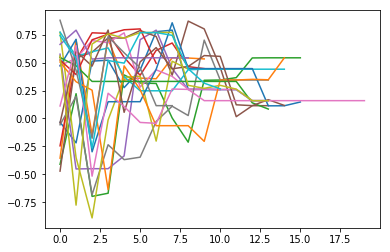

In [170]:
for rollout in rollouts:
    res = rollout[:,179]*sofa_std + sofa_mean
    res2 = np.copy(res)
    res = res[:-1]
    res2 = res2[1:]
    plt.plot(res2-res)
#     plt.show
    

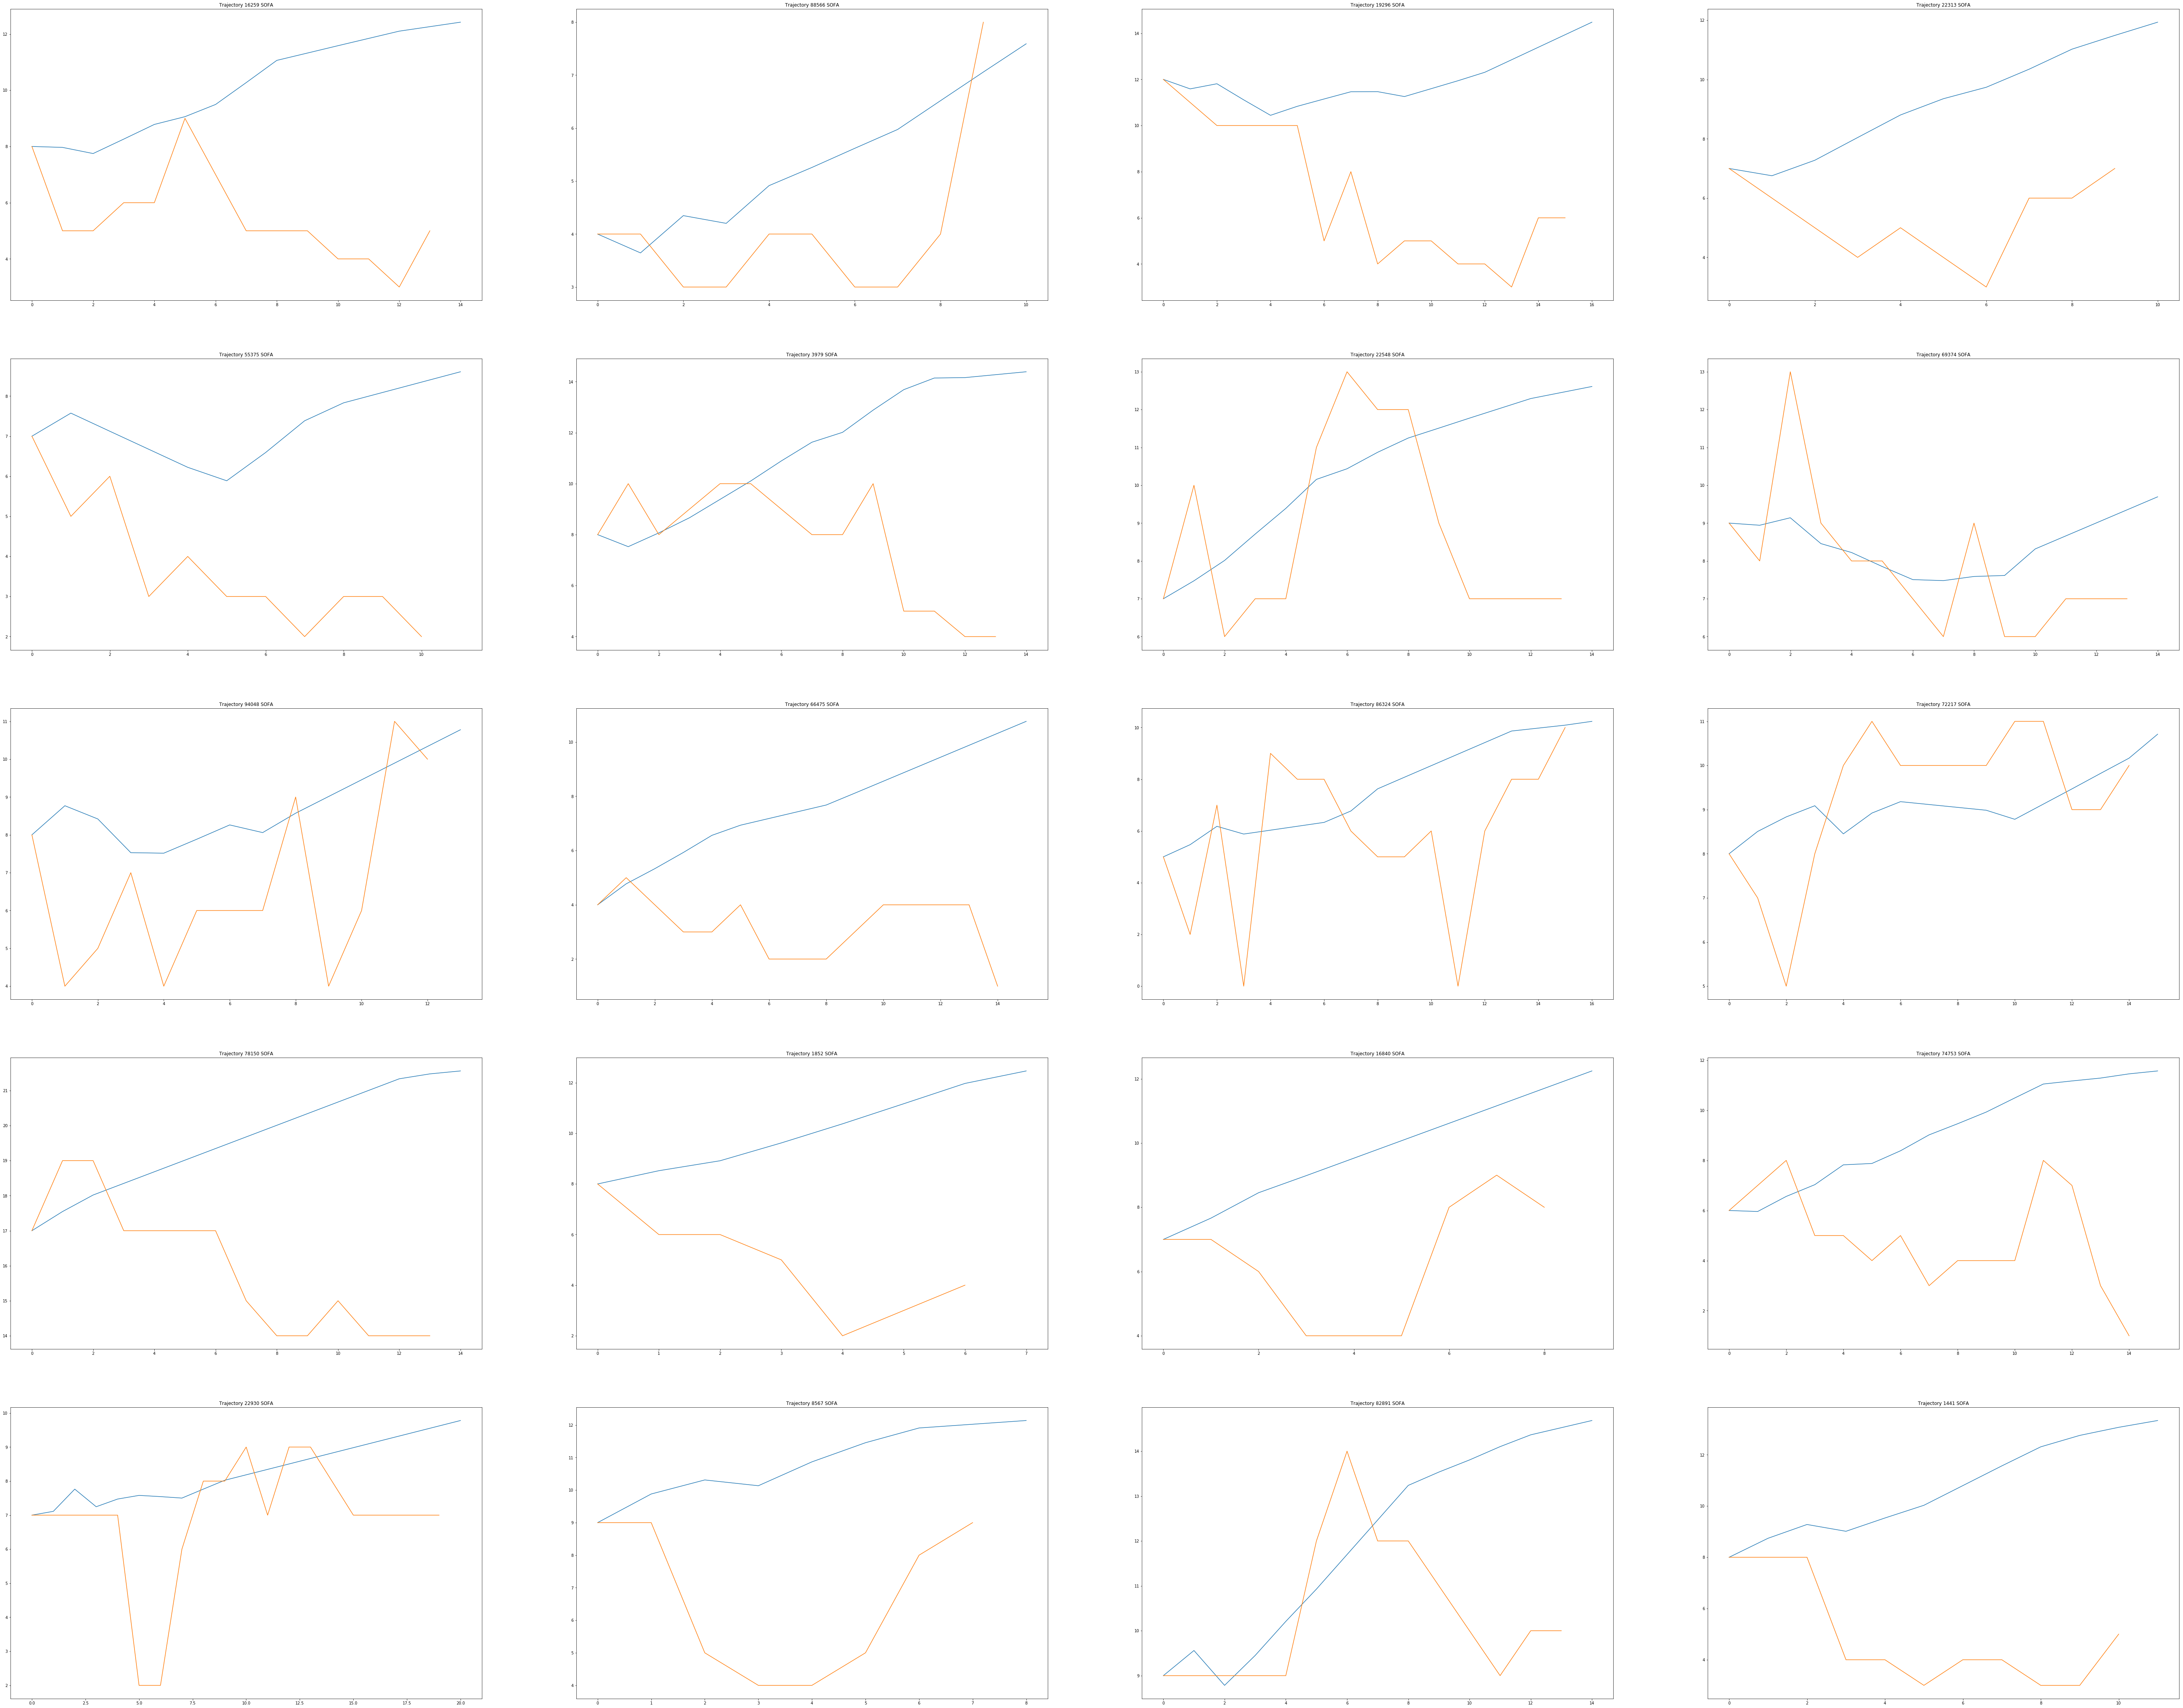

In [171]:
# make some plots
import matplotlib.pyplot as plt
%matplotlib inline
f, ax_arr = plt.subplots(5,4, figsize=(100,80))
unrolled_ax_arr = ax_arr.reshape(-1)
for i, traj_id in enumerate(traj_ids):
    ax = unrolled_ax_arr[i]
    rollout = rollouts[i]
    rel_segment = rel_entries.loc[rel_entries['icustayid']==traj_id]
    sofa_pred = rollout[:,179]*sofa_std + sofa_mean
    sofa_actual = rel_segment['SOFA'].values*sofa_std + sofa_mean
    ax.plot(sofa_pred)
    ax.plot(sofa_actual)
    ax.set_title("Trajectory %d SOFA" % traj_id)